## Part C- Demographic

In the demographic part, we try the different combination of dimensions, which are income level, age, home code, occupation, recency, frequency, and monetary, to find an improved segmentation of customer who has better response rate and a higher ROI.

In this part, we define one order as a response if it is made within 30 days after the customer receives a most recent contact. The response rate of one customer is defined by the total number of response divided by the total number of contacts. The response rate of one segmentation is defined by the total number of response divided by the total number of contacts of targeting customer group.

In the training set, we segment the customer base on specifically chosen dimensions and then calculate the total number of response and the number of customers falls in this segmentation. After estimating the response rate of each segmentation, we chose the segmentation which has a response rate higher than 0.03333 (the breakeven response rate), and then contact everyone in this group in the test set, to calculate the response and ROI.

Another thing in the table worth noticing is that there are a small group of customers who response exceptionally actively that the response rate of them is higher than 1. But the total amount of this kind of customers is relatively small.

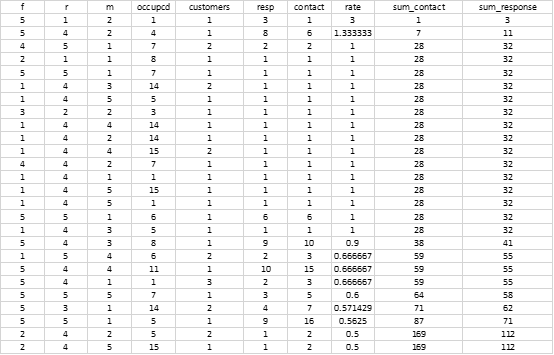

In the testing set, we calculate the response rate of each customer by dividing the total response by total contacts, and then in the marketing campaign, we will contact each of customer falls in the effective segmentation once by email. Using the response rate calculated in the test set, we can calculate the return and ROI of each segmentation. The final result is in the following table, from which we can draw three central insights from it.

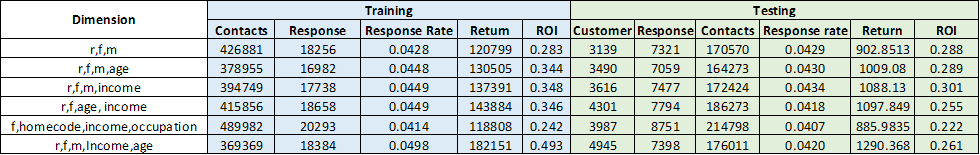

Firstly, when looking at the ROI in the testing result, we can see using recency, frequency, monetary and income dimensions will lead to the highest ROI. This result shows that by adding income as a new dimension into the segmentation process, we can improve the segmentation structure and find a group of customers responding contacts more actively.

Secondly, in the testing result, we can see the ROI of RFM dimensions is higher than that of RFAIc( recency, frequency, age, income), FHIcO(frequency, home code, income, occupation), and RFMIcA(recency, frequency, monetary, income, age). The reason behind this is that RFM segmentation contacts fewer customers who response less. However, the actual return of RFM segmentation is the lowest, comparing to others. This fact shows us that ROI is not a perfect way to evaluate the result of a digital campaign if the company focus on the actual profit.

Finally, we can see that there is a massive difference between the ROI of the training set and test set. For example, in the training set, the ROI of RFM plus income and age is highest among all segmentation methods, however, in the test set, the same outcome does not show up. That is a result of overfitting. In the training set, when segmenting with more dimensions, we can find more customer with higher response rate, thus bias decrease, but the variance will increase too, which may lead to a poor performance in the test set.


## Apendix- RFM + Demographic dimensions SQL code

The following SQL code produces the training outcome of RFM plus Income segmentation and replacing the relevant train table with test table created to give the result of the test set. Save the training outcome and testing outcome as two separate CSV files, which are provided in this submission too. After loading the training outcome table and testing table to pdAdmin, then use the SQL code in the next code cell to produce the outcome of the test set.

In [ ]:
WITH
	spend AS(
	SELECT
		cust_id,ordernum,orderdate,
		SUM(linedollars) as spent
	FROM lines
	GROUP BY cust_id,ordernum,orderdate
	HAVING orderdate>= 20050101
	),

	rfm AS(
	SELECT
		cust_id,
		MAX(orderdate) AS mostrecent,
		COUNT(*) AS frequency,
		AVG(spent) AS avgspend

	FROM
		spend
	LEFT JOIN orders as orders USING(ordernum, cust_id,orderdate)
	GROUP BY cust_id
),

sets AS(
SELECT *,
	    CASE
	        WHEN random() < 0.7 THEN 'training'
	        ELSE 'test'
	    END AS split
	FROM rfm),

train as (
	select * from sets
  where split='training' ),


rfm_train as(SELECT
	cust_id,
	mostrecent,
	NTILE(5) OVER (ORDER BY mostrecent ASC) as r,
	frequency,
	NTILE(5) OVER (ORDER BY frequency ASC) as f,
	avgspend,
	NTILE(5) OVER (ORDER BY avgspend ASC) as m

FROM train),

test as (
	select * from sets
  where split='test' ),


rfm_test as(SELECT
	cust_id,
	mostrecent,
	NTILE(5) OVER (ORDER BY mostrecent ASC) as r,
	frequency,
	NTILE(5) OVER (ORDER BY frequency ASC) as f,
	avgspend,
	NTILE(5) OVER (ORDER BY avgspend ASC) as m

FROM test),

custid as(SELECT rfm_train.cust_id
FROM rfm_train),

new_order as(SELECT custid.cust_id, orders.orderdate,orders.ordernum
FROM custid
LEFT JOIN orders
ON custid.cust_id = orders.cust_id
where orders.orderdate >=20050101),

resp_order as(SELECT  new_order.ordernum
FROM new_order
LEFT JOIN contacts
ON new_order.cust_id = contacts.cust_id
WHERE (contacts.contactdate - new_order.orderdate>=0 and contacts.contactdate - new_order.orderdate<=100)
GROUP BY new_order.ordernum),

res_train as(SELECT new_order.cust_id, count(*) as response_train
FROM new_order
INNER JOIN resp_order
ON new_order.ordernum = resp_order.ordernum
GROUP BY new_order.cust_id),

contact_num as(SELECT new_order.cust_id, count(distinct contacts.contactdate) as contact_train
FROM new_order
LEFT JOIN contacts
ON new_order.cust_id= contacts.cust_id
GROUP BY new_order.cust_id),

final_t as(select contact_num.cust_id, contact_train, coalesce(response_train,0) as response,r,f,m
from contact_num
left join res_train
on contact_num.cust_id = res_train.cust_id
left join rfm_train
on contact_num.cust_id = rfm_train.cust_id),

final_c as (select final_t.cust_id, r,f,m, contact_train,response,inccode, occupcd, homecode,agecode,dwelling
from final_t
inner join summary
on final_t.cust_id = summary.cust_id)

select r,f,m,inccode,count(cust_id) as customers, sum(response) as resp, sum(contact_train) as contact, 
sum(response)*1.0/NULLIF(sum(contact_train),0) as rate,
sum(count(cust_id)) over(order by  sum(response)*1.0/NULLIF(sum(contact_train),0) desc) as sum_customer,
sum(sum(response)) over(order by  sum(response)*1.0/NULLIF(sum(contact_train),0) desc) as sum_response
from final_c
group by(r,f,m,inccode)/*the latter two line of code should be removed when producing the testing outcome.*/
having (sum(response)*1.0/NULLIF(sum(contact_train),0) is not NULL and sum(response)*1.0/NULLIF(sum(contact_train),0) >=0.03333)
order by sum(response)*1.0/NULLIF(sum(contact_train),0) desc

In [ ]:
select sum(test.customers) as customer, sum(test.resp) as total_response, sum(test.contact) as total_contact,
(sum(test.resp)*30-sum(test.contact))/sum(test.contact) as roi
from test
inner join train
on test.f = train.f and
test.r = train.r and
test.inccode = train.inccode and
test.m = train.m